In [4]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [5]:
import pennylane as qml
from pennylane import qchem

from pennylane import numpy as np

symbols = ["Li", "H", "H"]
multiplicity = 2

In [6]:
from pennylane.templates import AllSinglesDoubles

energies = []
pes_point = 0

# get all the singles and doubles excitations, and Hartree-Fock state
electrons = 5
orbitals = 6
active_orbitals=6
singles, doubles = qchem.excitations(electrons, orbitals)



# loop to change reaction coordinate
r_range = np.arange(1.0, 8.0, 0.5)
for r in r_range:

    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, r, 0.0, 0.0, 8.0])

    # We now specify the multiplicity
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, mult=multiplicity, active_electrons=5,
    active_orbitals=6)
    print(qubits)
    hf = qml.qchem.hf_state(5, qubits)
    
    dev = qml.device("default.qubit", wires=qubits)
    opt = qml.GradientDescentOptimizer(stepsize=1.5)

    @qml.qnode(dev)
    def circuit(parameters):
        AllSinglesDoubles(parameters, range(qubits), hf, singles, doubles)
        return qml.expval(H)  # we are interested in minimizing this expectation value

    params = np.zeros(len(singles) + len(doubles), requires_grad=True)

    if pes_point > 0:
        params = params_old

    prev_energy = 0.0

    for n in range(50):
        params, energy = opt.step_and_cost(circuit, params)
        if np.abs(energy - prev_energy) < 1e-6:
            break
        prev_energy = energy

    # store the converged parameters
    params_old = params
    pes_point = pes_point + 1

    energies.append(energy)

12
12
12
12
12
12
12
12
12
12
12
12
12
12


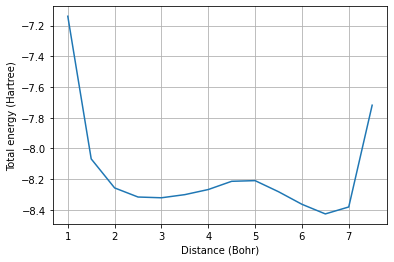

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(r_range, energies)

ax.set(
    xlabel="Distance (Bohr)",
    ylabel="Total energy (Hartree)",
)
ax.grid()
plt.show()

In [ ]:
# Energy of the reactants and products - two minima on the PES
e_eq1 = min(energies)
e_eq2 = min([x for x in energies if x != e_eq1])
print(e_eq1, e_eq2)
from scipy.signal import argrelextrema

print(argrelextrema(np.array(energies), np.less))

[idx1, idx2] = argrelextrema(np.array(energies), np.less)[0]

#idx2 = energies.index(e_eq2)

print(idx1, idx2)

# Transition state is the local maximum between reactant and products
idx_min = min(idx1, idx2)
idx_max = max(idx1, idx2)

# Transition state energy
energy_ts = max(energies[idx_min:idx_max])

# Activation energy
activation_energy = energy_ts - e_eq1

print(f"The activation energy is {activation_energy:.6f} Hartrees")

In [ ]:
# convert to joules
activation_energy *= 4.36e-18
# Boltzmann constant in Joules/Kelvin
k_B = 1.38e-23
# Temperature
T = 300

ratio = np.exp(activation_energy / (2 * k_B * T))

print(f"Ratio of reaction rates is {ratio:.0f}")